# Object Detection

In this assignment, you will implement a fruit detector. 
The task is divided into steps for simpler navigation.

Let's start!

In [ ]:
# we will need this library to process the labeling
! pip install xmltodict

In [ ]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import xmltodict
import json
import glob
import cv2
import os
import torchvision
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn

## Step 0. Dataset

First, let's load the data that you can download [here](https://drive.google.com/file/d/1Ve5e9qdy_sUCMM4qXWrw8ecURg2af9Cm/view?usp=sharing). 

We have already written a dataset class for you and we encourage you to figure out how it works.

In [ ]:
class2tag = {"apple": 1, "orange": 2, "banana": 3}


class FruitDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.images = []
        self.annotations = []
        self.transform = transform
        for annotation in glob.glob(data_dir + "/*xml"):
            image_fname = os.path.splitext(annotation)[0] + ".jpg"
            self.images.append(cv2.cvtColor(cv2.imread(image_fname), cv2.COLOR_BGR2RGB))
            with open(annotation) as f:
                annotation_dict = xmltodict.parse(f.read())
            bboxes = []
            labels = []
            objects = annotation_dict["annotation"]["object"]
            if not isinstance(objects, list):
                objects = [objects]
            for obj in objects:
                bndbox = obj["bndbox"]
                bbox = [bndbox["xmin"], bndbox["ymin"], bndbox["xmax"], bndbox["ymax"]]
                bbox = list(map(int, bbox))
                bboxes.append(torch.tensor(bbox))
                labels.append(class2tag[obj["name"]])
            self.annotations.append(
                {"boxes": torch.stack(bboxes).float(), "labels": torch.tensor(labels)}
            )

    def __getitem__(self, i):
        if self.transform:
            # the following code is correct if you use albumentations
            # if you use torchvision transforms you have to modify it
            res = self.transform(
                image=self.images[i],
                bboxes=self.annotations[i]["boxes"],
                labels=self.annotations[i]["labels"],
            )
            return res["image"], {
                "boxes": torch.tensor(res["bboxes"]),
                "labels": torch.tensor(res["labels"]),
            }
        else:
            return self.images[i], self.annotations[i]

    def __len__(self):
        return len(self.images)

## Step 1. Intersection over Union (10 points)

In the [Object Detection task](https://en.wikipedia.org/wiki/Object_detection), you need to find objects of a certain class on the image and locate their positions (using the bounding box). The  model should predict the coordinates of the bounding box `[x0, y0, x1, y1]` and the label for this box. The model can predict multiple candidate bounding boxes for an object. We will select candidates using [Intersection Over Union](https://en.wikipedia.org/wiki/Jaccard_index).

<img src=https://upload.wikimedia.org/wikipedia/commons/c/c7/Intersection_over_Union_-_visual_equation.png>


Implement a function that will calculate IoU for bounding boxes.

In [ ]:
def intersection_over_union(dt_bbox, gt_bbox):
    """
    Intersection over Union between two bboxes
    :param dt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :param gt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """
    ## YOUR CODE HERE
    dt_x0, dt_y0, dt_x1, dt_y1 = dt_bbox[0], dt_bbox[1], dt_bbox[2], dt_bbox[3]
    gt_x0, gt_y0, gt_x1, gt_y1 = gt_bbox[0], gt_bbox[1], gt_bbox[2], gt_bbox[3]

    area_of_overlap = (dt_x1 - gt_x0)*(dt_y1 - gt_y0)
    area_of_union = (dt_x1 - dt_x0)*(dt_y1 - dt_y0) + (gt_x1 - gt_x0)*(gt_y1 - gt_y0) - area_of_overlap
    
    iou = area_of_overlap/area_of_union
    
    return iou

If the function is implemented correctly, then the execution of the following cell will produce:

**0.14285714285714285**

In [ ]:
dt_bbox = [0, 0, 2, 2]
gt_bbox = [1, 1, 3, 3]
intersection_over_union(dt_bbox, gt_bbox)

0.14285714285714285

## Step 2. Evaluate Sample (15 points)

We now have to evaluate the predictions of the model. To do this, we will write a function that will do the following:
1. Take model predictions and ground truth bounding boxes and labels as inputs.
2. For each bounding box from the prediction, find the closest bounding box among the answers.
3. For each found pair of bounding boxes, check whether the IoU is greater than a certain threshold `iou_threshold`. If the **IoU** exceeds the threshold, then we consider this answer as **True Positive**.
4. Remove a matched bounding box from the evaluation.
5. For each predicted bounding box, return the detection score and whether we were able to match it or not.

In [ ]:
def evaluate_sample(target_pred, target_true, iou_threshold=0.5):
    # ground truth
    gt_bboxes = target_true['boxes'].numpy()
    gt_labels = target_true['labels'].numpy()

    # predictions
    dt_bboxes = target_pred['boxes'].numpy()
    dt_labels = target_pred['labels'].numpy()
    dt_scores = target_pred['scores'].numpy()

    results = []
    # for each bounding box from the prediction, find the closest bounding box among the answers
    for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]

        detection_result_dict = {'score': dt_score}

        ## YOUR CODE HERE
        max_gt_id = -1
        max_IoU = -float('inf')
        for i in range(len(gt_labels)):
          gt_bbox = gt_bboxes[i, :]
          gt_label = gt_labels[i]

          iou = intersection_over_union(dt_bbox, gt_bbox)
          if iou > max_IoU:
            max_IoU = iou
            max_gt_id = i
        
        if max_gt_id >= 0 and max_IoU >= iou_threshold:
            # mark as True Positive
            detection_result_dict['TP'] = 1
            # delete matched bounding box
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)

        else:
            detection_result_dict['TP'] = 0

        results.append(detection_result_dict)

    return results

## Step 3. Evaluate Model (15 points)

To assess the quality of the model, we will use the [mAP](https://jonathan-hui.medium.com/\map-mean-average-precision-for-object-detection-45c121a31173) metric defined as AP Area under the curve. To do this, you will need to calculate `recall` and` precision`.

In [ ]:
from sklearn.metrics import auc

In [ ]:
def evaluate(model, test_loader, device):
    results = []
    model.eval()
    nbr_boxes = 0
    with torch.no_grad():
        for batch, (images, targets_true) in enumerate(test_loader):
            images = list(image.to(device).float() for image in images)
            targets_pred = model(images)

            targets_true = [{k: v.cpu().float() for k, v in t.items()} for t in targets_true]
            targets_pred = [{k: v.cpu().float() for k, v in t.items()} for t in targets_pred]

            for i in range(len(targets_true)):
                target_true = targets_true[i]
                target_pred = targets_pred[i]
                nbr_boxes += target_true['labels'].shape[0]

                results.extend(evaluate_sample(target_pred, target_true))

    results = sorted(results, key=lambda k: k['score'], reverse=True)

    # compute precision and recall to calculate mAP
    positives = 0
    precision = []
    recall = []

    for i in range(nbr_boxes):
      if 'TP'in results[i]:
        if results[i]['TP'] == 1:
          positives += 1
        precision.append(positives/(i+1))
        recall.append(positives)
    
    recall = [num/positives for num in recall]

    ## YOUR CODE HERE

    return auc(recall, precision)

## Step 4. Train functions (30 points)

Now define the functions for training the model.

In [ ]:
def train_one_epoch(model, train_dataloader, optimizer, device):
    # YOUR CODE HERE
    # TRAIN YOUR MODEL ON THE train_dataloader
    for images, targets_true in train_dataloader:
      images = list(image.to(device).float() for image in images)
      targets_true = [{k: v.to(device) if k =='labels' else v.float().to(device) for k, v in t.items()} for t in targets_true]
      loss_dict = model(images,targets_true)
      
      losses = sum(loss for loss in loss_dict.values())
      loss_value = losses.item()

      optimizer.zero_grad()
      losses.backward()

      optimizer.step()


def train(model, train_dataloader, val_dataloader, optimizer, device, n_epochs=10):
    for epoch in range(n_epochs):
        model.eval()
        test_auc = evaluate(model, val_dataloader, device=device)
        print("AUC ON TEST: {:.4f}".format(test_auc))
        model.train()
        train_one_epoch(model, train_dataloader, optimizer, device=device)

## Step 5. Train model (30 points)

Train the model for object detection on a training dataset and achieve a PR-AUC of at least 0.91 on a test dataset. You can use models from `torchvision`.

It is mandatory to use augmentation for training to achieve the desired result on the test. Use the `torchvision.transforms` module or the [albumentations](https://albumentations.ai/) library. The latter library is especially convenient since it can calculate the new coordinates of bounding boxes itself after image transformations. We advise you to pay attention to this [tutorial](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/). Please note that the code written in the dataset above is only correct if you are using `albumentations`.

In [ ]:
!pip install --upgrade --force-reinstall --no-deps albumentations

  Using cached https://files.pythonhosted.org/packages/03/58/63fb1d742dc42d9ba2800ea741de1f2bc6bb05548d8724aa84794042eaf2/albumentations-0.5.2-py3-none-any.whl
  Found existing installation: albumentations 0.5.2
    Uninstalling albumentations-0.5.2:
      Successfully uninstalled albumentations-0.5.2


In [ ]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [ ]:
train_transform = A.Compose([
    A.Flip(0.5),
    A.Normalize(),
    ToTensorV2()           
], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
# YOUR CODE FOR AUGMENTATIONS
val_transform = A.Compose([
  A.Normalize(),                      
  ToTensorV2()
], bbox_params = {'format': 'pascal_voc', 'label_fields':['labels']})
# YOUR CODE FOR VALIDATION AUGMENTATIONS
# HINT: TRAIN TRANSFORM OBVIOUSLY SHOULD BE HARDER THAN THOSE FOR VALIDATION

# train_dataset = FruitDataset("./train_zip/train", transform=train_transform)
# val_dataset = FruitDataset("./test_zip/test", transform=val_transform)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

train_dataset = FruitDataset("/content/drive/My Drive/train_zip/train", transform=train_transform)
val_dataset = FruitDataset("/content/drive/My Drive/test_zip/test", transform=val_transform)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model = fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = 4

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
# YOUR CODE, CREATE MODEL FOR OBJECT DETECTION
# HINT: YOU CAN USE torchvision.models AND torchvision.models.detection
# READ OFFICIAL DOCS FOR MORE INFO


optimizer = torch.optim.SGD([p for p in model.parameters() if p.requires_grad], lr=0.005, momentum=0.9, weight_decay=0.0005)
# SELECT YOUR OPTIMIZER
train_dataloader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=lambda x: zip(*x)
)
# CREATE YOUR DATALOADER, SELECT APPROPRIATE batch_size
val_dataloader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=lambda x: zip(*x)
)
# CREATE VALIDATION DATALOADER
n_epochs = 10
# CUDA_LAUNCH_BLOCKING=1
# SELECT APPROPRIZTE NUMBER OF EPOCHS
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
train(model, train_dataloader, val_dataloader, optimizer, device, n_epochs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Streaming output truncated to the last 5000 lines.
        (2): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
        (3): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
      )
      (layer_blocks): ModuleList(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (extra_blocks): LastLevelMaxPool()
    )
  )
  (rpn): RegionProposalNetwork(
    (anchor_generator): AnchorGenerator()
    (head): RPNHead(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cls_logits): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
      (bbox_pred): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (roi_heads): RoIHeads(
    (box_roi_pool): MultiScaleRoIAlign(f

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Streaming output truncated to the last 5000 lines.
        (2): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
        (3): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
      )
      (layer_blocks): ModuleList(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (extra_blocks): LastLevelMaxPool()
    )
  )
  (rpn): RegionProposalNetwork(
    (anchor_generator): AnchorGenerator()
    (head): RPNHead(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cls_logits): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
      (bbox_pred): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (roi_heads): RoIHeads(
    (box_roi_pool): MultiScaleRoIAlign(f

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Streaming output truncated to the last 5000 lines.
        (2): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
        (3): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
      )
      (layer_blocks): ModuleList(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (extra_blocks): LastLevelMaxPool()
    )
  )
  (rpn): RegionProposalNetwork(
    (anchor_generator): AnchorGenerator()
    (head): RPNHead(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cls_logits): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
      (bbox_pred): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (roi_heads): RoIHeads(
    (box_roi_pool): MultiScaleRoIAlign(f

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Streaming output truncated to the last 5000 lines.
        (2): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
        (3): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
      )
      (layer_blocks): ModuleList(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (extra_blocks): LastLevelMaxPool()
    )
  )
  (rpn): RegionProposalNetwork(
    (anchor_generator): AnchorGenerator()
    (head): RPNHead(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cls_logits): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
      (bbox_pred): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (roi_heads): RoIHeads(
    (box_roi_pool): MultiScaleRoIAlign(f

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Streaming output truncated to the last 5000 lines.
        (2): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
        (3): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
      )
      (layer_blocks): ModuleList(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (extra_blocks): LastLevelMaxPool()
    )
  )
  (rpn): RegionProposalNetwork(
    (anchor_generator): AnchorGenerator()
    (head): RPNHead(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cls_logits): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
      (bbox_pred): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (roi_heads): RoIHeads(
    (box_roi_pool): MultiScaleRoIAlign(f

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Streaming output truncated to the last 5000 lines.
        (2): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
        (3): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
      )
      (layer_blocks): ModuleList(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (extra_blocks): LastLevelMaxPool()
    )
  )
  (rpn): RegionProposalNetwork(
    (anchor_generator): AnchorGenerator()
    (head): RPNHead(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cls_logits): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
      (bbox_pred): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (roi_heads): RoIHeads(
    (box_roi_pool): MultiScaleRoIAlign(f

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Streaming output truncated to the last 5000 lines.
        (2): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
        (3): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
      )
      (layer_blocks): ModuleList(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (extra_blocks): LastLevelMaxPool()
    )
  )
  (rpn): RegionProposalNetwork(
    (anchor_generator): AnchorGenerator()
    (head): RPNHead(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cls_logits): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
      (bbox_pred): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (roi_heads): RoIHeads(
    (box_roi_pool): MultiScaleRoIAlign(f

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Streaming output truncated to the last 5000 lines.
        (2): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
        (3): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
      )
      (layer_blocks): ModuleList(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (extra_blocks): LastLevelMaxPool()
    )
  )
  (rpn): RegionProposalNetwork(
    (anchor_generator): AnchorGenerator()
    (head): RPNHead(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cls_logits): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
      (bbox_pred): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (roi_heads): RoIHeads(
    (box_roi_pool): MultiScaleRoIAlign(f

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Streaming output truncated to the last 5000 lines.
        (2): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
        (3): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
      )
      (layer_blocks): ModuleList(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (extra_blocks): LastLevelMaxPool()
    )
  )
  (rpn): RegionProposalNetwork(
    (anchor_generator): AnchorGenerator()
    (head): RPNHead(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cls_logits): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
      (bbox_pred): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (roi_heads): RoIHeads(
    (box_roi_pool): MultiScaleRoIAlign(f

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Streaming output truncated to the last 5000 lines.
        (2): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
        (3): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
      )
      (layer_blocks): ModuleList(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (extra_blocks): LastLevelMaxPool()
    )
  )
  (rpn): RegionProposalNetwork(
    (anchor_generator): AnchorGenerator()
    (head): RPNHead(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cls_logits): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
      (bbox_pred): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (roi_heads): RoIHeads(
    (box_roi_pool): MultiScaleRoIAlign(f

Output the final quality of the model.

In [ ]:
evaluate(model, val_dataloader, device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

0.9253008457124566

Draw predicted bounding boxes for any two images from the test dataset.

In [ ]:
image, labels = next(iter(train_dataset))
pred = model(image.unsqueeze(0).to(device))[0]

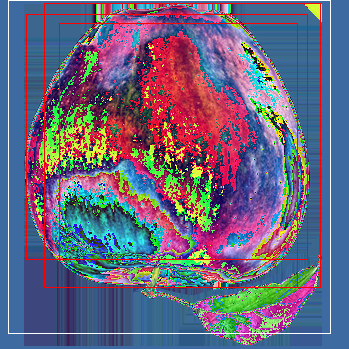

In [ ]:
from PIL import ImageDraw

image = torchvision.transforms.ToPILImage()(image)
draw = ImageDraw.Draw(image)
for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
    
for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image